# Analyse de sentiments

C'est désormais un problème classique de machine learning. D'un côté, du texte, de l'autre une appréciation, le plus souvent binaire, positive ou négative mais qui pourrait être graduelle.

## Les données

On récupère les données depuis le site UCI [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences). 

Il y a trois fichiers textes à importer et à concaténer pour former un dataset avec deux colonnes:
- Une "texte" comportant le contenu du commentaire
- Une "sentiment" comportant une note de 0 ou 1

#### Questions préalables: 
- Quelle est la taille du dataset ?
- Comment est distribuée la variable sentiment ?


#### Question 1: Combien y a t'il de mots dans l'ensemble du corpus ? Sont-ils "homogènes" ? 


### Import du module permettant le traitement de texte: nltk

In [1]:
import re
import nltk
import pandas as pd
import os, glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

In [2]:
files_folder = "data/"

path_amazon = os.path.join(files_folder, 'amazon_cells_labelled.txt')
df_amazon = pd.read_table(path_amazon, sep='\t', header=None, engine='python').rename({0:'Sentence', 1:'Score'}, axis=1)
print(df_amazon.shape)
print("--------------")
df_amazon.head()

(1000, 2)
--------------


,Sentence,Score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [3]:
path_imdb = os.path.join(files_folder, 'imdb_labelled.txt')
df_imdb = pd.read_table(path_imdb, sep='\t(0|1)', header=None, engine='python').drop([2], axis=1).rename({0:'Sentence', 1:'Score'}, axis=1)
print(df_imdb.shape)
print("--------------")
df_imdb.head()

(1000, 2)
--------------


,Sentence,Score
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [4]:
path_yelp = os.path.join(files_folder, 'yelp_labelled.txt')
df_yelp = pd.read_table(path_yelp, sep='\t', header=None, engine='python').rename({0:'Sentence', 1:'Score'}, axis=1)
print(df_yelp.shape)
print("--------------")
df_yelp.head()

(1000, 2)
--------------


,Sentence,Score
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [5]:
lst_df=[df_amazon, df_imdb, df_yelp]
df = pd.concat(lst_df)

In [6]:
df.head()

,Sentence,Score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


(3000, 2)
------------------------------------
Sentence    object
Score        int64
dtype: object
------------------------------------
Sentence    0
Score       0
dtype: int64
------------------------------------


<AxesSubplot:>

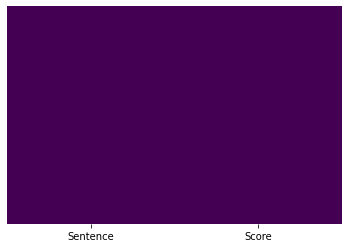

In [7]:
print(df.shape)
print('------------------------------------')
print(df.dtypes)
print('------------------------------------')
print(df.isna().sum())
print('------------------------------------')
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### Consigne 1: Récupérer le corpus de mots sans la ponctuation ni les stopwords

In [8]:
def clean_Review(review_text):
    stop_words = stopwords.words('english')
    review_text = str(review_text).lower().strip()
    review_text = re.sub('[^a-zA-Z]', " ", review_text)
    review_text = word_tokenize(review_text)
    review_text = [word for word in review_text if word not in stop_words]
    review_text = [WordNetLemmatizer().lemmatize(word=w, pos='v') for w in review_text]
    review_text = [w for w in review_text if len(w) > 2]
    review_text = ' '.join(review_text)
    return review_text

df['Clean_Sentence'] = df['Sentence'].apply(clean_Review)

In [9]:
df.head()

,Sentence,Score,Clean_Sentence
0,So there is no way for me to plug it in here i...,0,way plug unless converter
1,"Good case, Excellent value.",1,good case excellent value
2,Great for the jawbone.,1,great jawbone
3,Tied to charger for conversations lasting more...,0,tie charger conversations last minutes major p...
4,The mic is great.,1,mic great


#### Question 2: Combien de mots restent-ils ? 

In [10]:
word_list = pd.Series(' '.join(df['Clean_Sentence']).split())

In [11]:
print("Nombre de mots dans le corpus : ", len(word_list))
print('---------------------------------------------')
print("Nombre de mots unique dans le corpus : ", word_list.nunique())

Nombre de mots dans le corpus :  17727
---------------------------------------------
Nombre de mots unique dans le corpus :  4138


## Exercice 1 : approche td-idf

La cible est la colonne *sentiment*, les deux autres colonnes sont les features. Il faudra utiliser les prétraitements [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). L'un d'entre eux n'est pas nécessaire depuis la version [0.20.0](http://scikit-learn.org/stable/whats_new.html#sklearn-preprocessing) de *scikit-learn*.

#### Consigne 2: Utiliser OneHotEncoder ou CountVectorizer pour représenter les données sous forme d'une matrice contenant autant de colonnes que de mots dans le corpus

In [12]:
vectorizer = CountVectorizer()
corpus = df['Clean_Sentence']
wob = vectorizer.fit_transform(corpus)

In [13]:
wob.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [14]:
wob.shape

(3000, 4138)

**Nous avons bien les 4138 mots uniques du corpus en columns.**

#### Consigne 3: lancer un modèle de classification pour prédire les sentiments de 30% des observations



*   Séparer échantillon train / test
*   Entrainer un modèle de classification
*   Afficher la matrice de confusion
*   Calculer l'accuracy, la précision et le recall
*   Votre modèle est-il soumis à un overfitting ?

In [15]:
X = df['Clean_Sentence']
y = df['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = CountVectorizer()

train_countvect = vectorizer.fit_transform(X_train)
test_countvect = vectorizer.transform(X_test)

print('Train : ' , train_countvect.shape)
print('Test :' , test_countvect.shape)

Train :  (2100, 3361)
Test : (900, 3361)


**RandomForest**

In [16]:
rf = RandomForestClassifier()
rf.fit(train_countvect, y_train)

acc_rf = rf.score(test_countvect, y_test)

acc_rf

0.7911111111111111

**KNeighborsClassifier**

In [17]:
knn = KNeighborsClassifier() 
knn.fit(train_countvect, y_train)  
 
acc_knn = knn.score(test_countvect, y_test)
acc_knn

0.6633333333333333

**LogisticRegression**

In [18]:
logit = LogisticRegression()
logit.fit(train_countvect, y_train)

acc_logit = logit.score(test_countvect, y_test)
acc_logit

0.7944444444444444

**Naive bayes**

In [19]:
mnb = MultinomialNB()
mnb.fit(train_countvect, y_train)
acc_mnb = mnb.score(test_countvect, y_test)
acc_mnb

0.8088888888888889

In [20]:
gnb = GaussianNB()
gnb.fit(train_countvect.todense(), y_train)
acc_gnb = gnb.score(test_countvect.todense(), y_test)
acc_gnb 

0.6422222222222222

In [21]:
results = pd.DataFrame({
    'Model': ['KNN', 'LogisticRegression', 'RandomForest', 'MultinomialNB', 'GaussianNB'],
    'Score': [ acc_knn, acc_logit, acc_rf, acc_mnb, acc_gnb]
    })
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model
Score,
0.808889,MultinomialNB
0.794444,LogisticRegression
0.791111,RandomForest
0.663333,KNN
0.642222,GaussianNB


**MultinomialNB semble ici le plus efficace. Je vais donc me concentré sur cette algorithme**

In [22]:
parameters = {
              'fit_prior': (True, False),
              'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
              }

mnb_grid=GridSearchCV(mnb, parameters, cv=10)
mnb_grid.fit(train_countvect, y_train)

print("tuned hpyerparameters :(best parameters) ", mnb_grid.best_params_)
print("accuracy :", mnb_grid.best_score_)

tuned hpyerparameters :(best parameters)  {'alpha': 1, 'fit_prior': True}
accuracy : 0.7976190476190477


In [23]:
# mnb_grid.score(test_countvect, y_test)

In [24]:
# mnb_grid.cv_results_.keys()

In [25]:
mnb_grid.fit(train_countvect, y_train)
acc_mnb = mnb_grid.score(test_countvect, y_test)
acc_mnb

0.8088888888888889

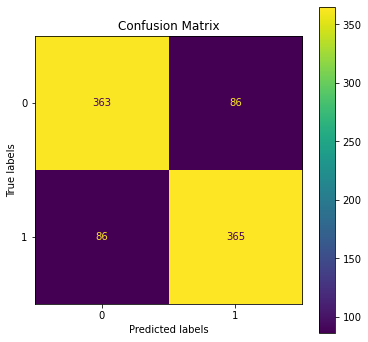

In [26]:
predictions = cross_val_predict(mnb_grid, test_countvect, y_test, cv=10)
cf_matrix = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(mnb_grid, test_countvect, y_test, ax=ax)  

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()

In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       449
           1       0.78      0.74      0.76       451

    accuracy                           0.77       900
   macro avg       0.77      0.77      0.77       900
weighted avg       0.77      0.77      0.77       900



#### Consigne 4: Utiliser TF-IDF pour représenter les données et relancer un modèle de classification

In [27]:
vectorizer = TfidfVectorizer()

train_tfidf = vectorizer.fit_transform(X_train)
test_tfidf = vectorizer.transform(X_test)

print('Train : ' , train_tfidf.shape)
print('Test :' , test_tfidf.shape)

Train :  (2100, 3361)
Test : (900, 3361)


In [28]:
knn = KNeighborsClassifier() 
knn.fit(train_tfidf, y_train)  
 
acc_knn = knn.score(test_tfidf, y_test)
acc_knn

0.7388888888888889

In [29]:
logit = LogisticRegression()
logit.fit(train_tfidf, y_train)

acc_logit = logit.score(test_tfidf, y_test)
acc_logit

0.8011111111111111

In [28]:
rf = RandomForestClassifier()
rf.fit(train_tfidf, y_train)

acc_rf = rf.score(test_tfidf, y_test)

acc_rf

0.7722222222222223

**MultinomialNB**

In [29]:
mnb = MultinomialNB()
mnb.fit(train_tfidf, y_train)
acc_mnb = mnb.score(test_tfidf, y_test)
acc_mnb

0.8122222222222222

**GaussianNB**

In [31]:
gnb = GaussianNB()
gnb.fit(train_tfidf.todense(), y_train)
acc_gnb = gnb.score(test_tfidf.todense(), y_test)
acc_gnb 

0.6566666666666666

In [32]:
results2 = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Random Forest', 'MultinomialNB', 'GaussianNB'],
    'Score': [ acc_knn, acc_logit, acc_rf, acc_mnb, acc_gnb]
    })
result_df2 = results2.sort_values(by='Score', ascending=False)
result_df2 = result_df2.set_index('Score')
result_df2

,Model
Score,
0.808889,MultinomialNB
0.801111,Logistic Regression
0.791111,Random Forest
0.738889,KNN
0.656667,GaussianNB


In [33]:
parameters = {
              'fit_prior': (True, False),
              'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
              }

mnb_grid=GridSearchCV(mnb, parameters, cv=10)
mnb_grid.fit(train_tfidf, y_train)

print("tuned hpyerparameters :(best parameters) ", mnb_grid.best_params_)
print("accuracy :", mnb_grid.best_score_)

tuned hpyerparameters :(best parameters)  {'alpha': 1, 'fit_prior': True}
accuracy : 0.8047619047619048


In [ ]:
logit_grid = LogisticRegression(C = 1.623776739188721, penalty= 'l2', solver= 'liblinear',  max_iter=1000)
logit_grid.fit(train_tfidf, y_train)

acc_logit_grid = logit_grid.score(test_tfidf, y_test)
acc_logit_grid

0.8011111111111111

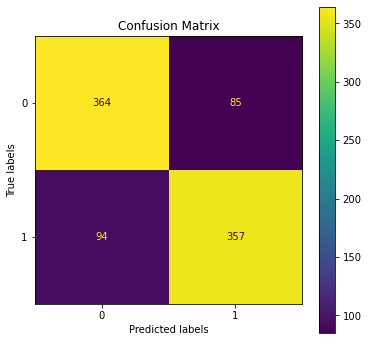

In [ ]:
predictions = cross_val_predict(logit_grid, test_tfidf, y_test, cv=10)
cf_matrix = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(logit_grid, test_tfidf, y_test, ax=ax)  

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.78      0.77       449
           1       0.77      0.74      0.76       451

    accuracy                           0.76       900
   macro avg       0.76      0.76      0.76       900
weighted avg       0.76      0.76      0.76       900



In [ ]:
print('Modèles avec CountVectorize')
print('-----------------------------')
print(result_df)
print('')
print('')
print('Modèles avec TF-IDF')
print('-----------------------------')
print(result_df2)

Modèles avec CountVectorize
-----------------------------
                        Model
Score                        
0.808889          Naive bayes
0.794444  Logistic Regression
0.780000        Random Forest
0.663333                  KNN


Modèles avec TF-IDF
-----------------------------
                        Model
Score                        
0.812222          Naive bayes
0.801111  Logistic Regression
0.785556        Random Forest
0.738889                  KNN


In [48]:
test_tfidf.shape

(900, 3361)

## Exercice 2 : word2vec

On utilise l'approche [word2vec](https://en.wikipedia.org/wiki/Word2vec) du module [gensim](https://radimrehurek.com/gensim/models/word2vec.html) ou [spacy](https://spacy.io/usage/vectors-similarity).

#### Consigne 5: Utiliser Word2vec pour représenter les données et relancer un modèle de classification

## Exercice 3 : Comparer les deux approches

#### Consigne 6: Faire un graphique montrant les courbes ROC associées au deux modèles

#### Consigne 7: Faire un graphique montrant les courbes Precision-Recall associées aux deux modèles

### BONUS: reprendre l'étape de One_hot_encoding et ajouter une étape de réduction de dimension (type ACP)